# Exploratory data analysis and feature selection: Random Forest

Fabiana Castiblanco

https://github.com/fabi-cast

## Conclusions from EDA

* Philipines, China, Japan, Mexico, Vietnam, United States and Madagascar are the countries with highest occurrence of cyclones. In GitHub, please see the static image [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/map.png)

* By far, most of the storms for which we have data have occurred in **Western North Pacific** basin.

* We observed that the distribution of the logarithm natural of our target variable is approximately normal, so ``TOTAL_AFFECTED`` has a distribution log normal. For this reason, when studying the relevance of the categorical features as ``BASIN``, ``SUB BASIN`` and ``GENERAL_CATEGORY`` in the target variable, we will consider the aggregated function as the **mean** of the data.

* After introduction of the variable ``GENERAL_CATEGORY`` which classify the cyclone according with the maximum sustained winds it tooks during their trajectory, we have a much better landscape. Most of our cyclones are **Tropical Storms** and **Hurricanes Category 1 and 4**. Generally, after a cyclone reach winds which classify it as Category 1, there are affected population and some infrastructure damages.

* In the Westert North Pacific basin, for which we have most data, **the mean affected people by the cyclone is going upwards most of the time when the category of the cyclone increases**. After this, we will include the feature ``GENERAL_CATEGORY`` as a dummy variable in our data set.

* In general, countries with higher income level have less affected population in each cyclone category. Critical sectors are countries with ``INCOME_LEVEL`` Low middle and High Middle. We will include ``INCOME_LEVEL`` as a dummy variable in our data set.

* The top 10 most important features, out of the a posteriori ones (``TOTAL_DEATHS`` AND ``TOTAL_DAMAGE``), are:
    * 34_KN_POP
    * Rural population
    * 64_KN_POP
    * Rural population share
    * Human Development Index (HDI)
    * GDP per capita
    * Total hours in land
    * 96_KN_POP
    * Landing (yes/no)
    * Minimum distance to land

None of the a priori variables shows high correlation in general. 

* Almost **3 of each 4 cyclones present in our data did land**. Those landing cyclones are responsible for **almost 95% of the affected population in our data**. 


## Conclusions from modeling task

* By adding new features to the data set, we obtain a R^2 score of 0.30 without scaling our data set. On the other hand, we got a RMSE of 1'606312 people and a Median Absolute error of 230201 people. 

* Using logarithmic transformation in the population variables, we don't see any improvement in the R^2 score or RMSE. On the contrary, those two metrics drop after such transformation.

* Using all the features given in the data set it is harmful for the model itself. There are so many variables not explanatory, most of them comming from socio-economical indicators.

* The recurrent most important features are:

    * RURAL_POP
    * POP_MAX_34_ADJ
    * MAX_WIND
    * RURAL_POP (%)
    * POP_MAX_50_ADJ
    * MAX_STORMSPEED
    * VLAND_KN
    * LON_MAX_WINDS
    * LAT_MIN_DIST2LAND
    * TOTAL_HOURS_INLAND
    * POP_MAX_64_ADJ

## 1. Import libraries


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import math
import requests
import json
import matplotlib
from pandas import ExcelFile
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import reverse_geocoder as rg
import ast
import statsmodels.api as sm
import pickle
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)
import sklearn
matplotlib.rc('image', cmap='Set3')
from plotly import graph_objects as go
import plotly.express as px
from scicolorscales import *
from plotly.subplots import make_subplots

# 2. Functions to handling data

In [2]:
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

def get_country_list(ds, col):
    
    """
    Returns a list containing the countries or ISO codes in the dataset ds
    """
    return list(ds[col])

#this function converts a row oriented data set in a columns oriented one

def get_data(ds, country, col, col_name):
    
    """
    Creates a dataset for each country containing the features in col_name.
    ds is the original data set, col is the name of the column containing information about
    countries and col_name is the desired feature to get from ds
    """
    ind = get_country_list(ds, col).index(country)
    data = (ds[ds[col] == country].drop(columns = [col])
                                  .T.reset_index()
                                  .rename(columns = {"index": "year", ind: col_name}))
    data["country"] = country
    return data

def get_table(ds, col, col_name):
    
    """
    Creates a dataset column oriented based on row oriented ds
    """
    
    country_list = get_country_list(ds, col)
    datasets = [get_data(ds, country, col, col_name) for country in country_list]
    return pd.concat(datasets).reset_index(drop = True)
    


# 3. Loading data

In [3]:
df = pd.read_excel("Data_output/clean.xls").drop(columns = "Unnamed: 0")

In [4]:
ds = pd.read_excel("Data_output/final_data.xls").drop(columns = "Unnamed: 0")

In [5]:
df.head()

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_START,DATE_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,TOTAL_AFFECTED,pop_max_34,pop_max_50,pop_max_64,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj
0,1949163N07145,DELLA,WP,WP,JPN,1949,6,1949-06-19 09:00:00,1949-06-24 06:00:00,117.0,60.0,TS,28.91410,129.573,33.5183,130.973,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,194046,16431894.0,7958809.0,4553851.00,1.198300e+07,5.803981e+06,3.320907e+06
1,1950241N23140,JANE,WP,WP,JPN,1950,8,1950-08-30 03:00:00,1950-09-05 00:00:00,141.0,21.0,ET,29.12010,133.762,36.1016,136.095,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,642117,43343320.0,21380746.0,13972339.00,3.160822e+07,1.559196e+07,1.018936e+07
2,1951224N12316,CHARLIE,NAm,CS,JAM,1951,8,1951-08-17 21:00:00,1951-08-18 12:00:00,15.0,3.0,TS,17.60000,-76.200,17.9000,-76.900,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,20200,2753687.5,2750167.0,1948090.75,1.689243e+06,1.687083e+06,1.195052e+06
3,1951337N09150,AMY,WP,WP,PHL,1951,12,1951-12-07 09:00:00,1951-12-17 00:00:00,231.0,36.0,TS,11.78330,127.900,10.5340,123.174,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,60000,14131997.0,8926450.0,3309632.25,4.760039e+06,3.006670e+06,1.114774e+06
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,1952-07-01 06:00:00,1952-07-04 18:00:00,84.0,9.0,TS,9.56613,127.791,10.6492,123.239,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,103,15232730.0,8281656.5,5903694.00,5.130796e+06,2.789486e+06,1.988524e+06


In [6]:
ds["COORDS"] = ds.COORDS.apply(lambda x: ast.literal_eval(x))
ds["ISO_TIME"] = ds.ISO_TIME.apply(lambda x: ast.literal_eval(x))

In [7]:
indicators_data = ds[["SID", "ISO", "YEAR", 'POP_DEN_SQ_KM','RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'hdi']].copy()

In [8]:
indicators_data.drop_duplicates(keep = "first", inplace = True)

In [9]:
model_data = df.merge(indicators_data, on = ["SID", "ISO", "YEAR"], how ="left")

In [10]:
null_cols(model_data)

,Feature,% Null rows
0,pop_max_64_adj,8.016032
1,pop_max_50_adj,8.016032
2,pop_max_34_adj,8.016032
3,pop_max_64,8.016032
4,pop_max_50,8.016032
5,pop_max_34,8.016032
6,MAX_STORMSPEED,0.200401


In [11]:
model_data.columns = [col.upper() for col in model_data.columns]

In [12]:
model_data.head()

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_START,DATE_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,TOTAL_AFFECTED,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI
0,1949163N07145,DELLA,WP,WP,JPN,1949,6,1949-06-19 09:00:00,1949-06-24 06:00:00,117.0,60.0,TS,28.91410,129.573,33.5183,130.973,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,194046,16431894.0,7958809.0,4553851.00,1.198300e+07,5.803981e+06,3.320907e+06,195.0,77.20,81700000,63072400.0,0.816
1,1950241N23140,JANE,WP,WP,JPN,1950,8,1950-08-30 03:00:00,1950-09-05 00:00:00,141.0,21.0,ET,29.12010,133.762,36.1016,136.095,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,642117,43343320.0,21380746.0,13972339.00,3.160822e+07,1.559196e+07,1.018936e+07,227.0,47.00,82800000,38916000.0,0.816
2,1951224N12316,CHARLIE,NAm,CS,JAM,1951,8,1951-08-17 21:00:00,1951-08-18 12:00:00,15.0,3.0,TS,17.60000,-76.200,17.9000,-76.900,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,20200,2753687.5,2750167.0,1948090.75,1.689243e+06,1.687083e+06,1.195052e+06,133.0,66.23,1440000,953712.0,0.668
3,1951337N09150,AMY,WP,WP,PHL,1951,12,1951-12-07 09:00:00,1951-12-17 00:00:00,231.0,36.0,TS,11.78330,127.900,10.5340,123.174,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,60000,14131997.0,8926450.0,3309632.25,4.760039e+06,3.006670e+06,1.114774e+06,64.5,75.35,19200000,14467200.0,0.590
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,1952-07-01 06:00:00,1952-07-04 18:00:00,84.0,9.0,TS,9.56613,127.791,10.6492,123.239,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,103,15232730.0,8281656.5,5903694.00,5.130796e+06,2.789486e+06,1.988524e+06,66.9,72.41,19900000,14409590.0,0.590


In [13]:
df_or = pd.read_csv("OUTPUT_WBI_exposer_cyclones_v14.csv", sep = ";")

In [14]:
df_or["DATE_START"] = pd.to_datetime(df_or["DATE_START"])
df_or["DATE_END"] = pd.to_datetime(df_or["DATE_END"])

In [15]:
dff = df_or.merge(model_data[["SID", "ISO", "NAME", "YEAR", "LAT_MAX_WINDS", "LON_MAX_WINDS", "LAT_MIN_DIST2LAND", "LON_MIN_DIST2LAND", "RURAL_POP", "HDI"]],
            on = ["SID", "ISO", "NAME", "YEAR"], how = "left")

In [16]:
dff.drop(columns = ["COORDS", "COORDS_MAX_WINDS", "COORDS_MIN_DIST2LAND", "HDI_x"], inplace= True)

In [17]:
dff.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'TOTAL_AFFEC

In [18]:
dff = dff[['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'MONTH_START',
               'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
               'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
               'LAT_MAX_WINDS', 'LON_MAX_WINDS',
               'LAT_MIN_DIST2LAND', 'LON_MIN_DIST2LAND',
               'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
               'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
               'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
               '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
               'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP', 'RURAL_POP(%)',
               'HDI_y', 'Arable land (hectares per person)',
               'Cereal yield (kg per hectare)',
               'Food production index (2004-2006 = 100)',
               'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
               'Life expectancy at birth, total (years)',
               'Adjusted savings: education expenditure (% of GNI)',
               'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
               'POP_MAX_64_ADJ', 'TOTAL_AFFECTED']] 

In [19]:
dff.rename(columns = {'Arable land (hectares per person)': "ARABLE_LAND", 
                        'Cereal yield (kg per hectare)': "CEREAL_YIELD",
                        'Food production index (2004-2006 = 100)': "FOOD_PRODUCTION_INDEX",
                        'GDP per capita (constant 2010 US$)': "GDP_PC", 
                        'Net flows from UN agencies US$': "NET_FLOWS_FROM_UN",
                       'Life expectancy at birth, total (years)': "LIFE_EXPECTANCY",
                       'Adjusted savings: education expenditure (% of GNI)': "EDUCATION_EXPENDITURE",
                        'Income_level_Final': "INCOME_LEVEL",
                        "HDI_y": "HDI"}, inplace= True)

In [20]:
model_data2 = dff.copy()

# 4. Exploring categorical data

We should ensure that our categorical variables are of this type.

In [21]:
model_data2['BASIN'] = model_data2['BASIN'].astype('category')
model_data2['SUB BASIN'] = model_data2['SUB BASIN'].astype('category')
model_data2['NATURE'] = model_data2['NATURE'].astype('category')
model_data2['GENERAL_CATEGORY'] = model_data2['GENERAL_CATEGORY'].astype('category')
model_data2['MAX_USA_SSHS'] = model_data2['MAX_USA_SSHS'].astype('category')
model_data2['YEAR'] = model_data2['YEAR'].astype('category')

In [22]:
model_data2.dtypes

SID                                object
NAME                               object
ISO                                object
YEAR                             category
BASIN                            category
SUB BASIN                        category
MONTH_START                         int64
MONTH_END                           int64
DATE_START                 datetime64[ns]
DATE_END                   datetime64[ns]
DATE_LAND_START                    object
DATE_LAND_END                      object
TOTAL_HOURS_EVENT                 float64
TOTAL_HOURS_IN_LAND               float64
NATURE                           category
LAT_MAX_WINDS                     float64
LON_MAX_WINDS                     float64
LAT_MIN_DIST2LAND                 float64
LON_MIN_DIST2LAND                 float64
GENERAL_CATEGORY                 category
MAX_WIND                          float64
MIN_PRES                            int64
MIN_DIST2LAND                       int64
MAX_STORMSPEED                    

As ``SUB BASIN`` is more granular than ``BASIN``, we drop this column because.

In [23]:
model_data2.drop(columns= "BASIN", inplace= True)

## 4.3. Exploring ordinal and categorical data

### 4.3.1. Number of cyclones in the last 70 years.

The data available for our study, just contains cyclones with people affected reported to EMDAT and it is only complete up to 2019. 

In [24]:
number_cyclones = model_data2.groupby('YEAR')[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Nº_cyclones"})

In [25]:
number_cyclones['YEAR'] = number_cyclones['YEAR'].astype(int)

In [203]:
fig = px.bar(number_cyclones, 
             x= "YEAR", 
             y = "Nº_cyclones",
             color = "YEAR",
             color_continuous_scale = 'teal',
             labels = {'YEAR':"Year", "Nº_cyclones": 'Number of cyclones'},
             template ='plotly_white')
# List of cyclones by occurrence
fig.update_layout(
    title_text = 'Occurrence of cyclones since 1948: Data Affected population available')

fig.show() 


In [27]:
cyc_general = pd.read_csv('Data_output/cyclones_general.csv')

In [28]:
cyc_general = cyc_general.merge(number_cyclones, on = 'YEAR', how= 'left').rename(columns = {'Nº_cyclones_x': "Ibtracs data",
                                                                               'Nº_cyclones_y': "Available data" })

In [29]:
cyc_general

,YEAR,Ibtracs data,Available data
0,1948,10,NaN
1,1949,307,1.0
2,1950,341,1.0
3,1951,328,2.0
4,1952,331,1.0
...,...,...,...
68,2016,317,35.0
69,2017,341,37.0
70,2018,380,34.0
71,2019,285,6.0


### Data availability: Affected population

When we explore the ibtracs dataset, which does not make any considerations to the impact the cyclones have had, we see **how little available data there is regarding observed impact after cyclones occurred**. We capture a very small part of all the cyclone activity over the world, exploring data from sources like Emdat and wiki-scrapping.

As we will see later, this fact does not allow us to create a model with good accuracy metrics.

In [31]:
fig = go.Figure()
fig.add_trace(go.Bar(x=cyc_general['YEAR'],
                y=cyc_general['Ibtracs data'],
                name='Ibtracs data',
                marker_color='rgb(167,211,212)'))
                                   
fig.add_trace(go.Bar(x=cyc_general['YEAR'],
                y=cyc_general['Available data'],
                name='Data including affected population',
                marker_color='rgb(199, 93, 171)' #'rgb(214, 145, 193)'#'rgb(221,160,221)'
                ))

fig.update_layout(
    title='Occurrence of cyclones since 1948',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of cyclones',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='stack',
    template = 'plotly_white',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

### 4.3.2. Storms by  General Category

**What is the share of storms by category present in our core dataset?**

In [32]:
cyc_cat = model_data2.groupby('GENERAL_CATEGORY')[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Number of cyclones"}).sort_values('Number of cyclones', ascending = False)

In [33]:
cyc_cat

,GENERAL_CATEGORY,Number of cyclones
6,TS,249
3,Cat 4,196
0,Cat 1,195
2,Cat 3,124
1,Cat 2,120
4,Cat 5,74
5,TD,33


In [34]:
fig = px.bar(cyc_cat, 
             x= "GENERAL_CATEGORY", 
             y = "Number of cyclones",
             color = "Number of cyclones",
             color_continuous_scale = "Tropic_r",
            labels = {"GENERAL_CATEGORY": "Category"},
            template = 'plotly_white')

fig.update_layout(
    title_text = 'Cyclones by General Category')


fig.show() 


After introduction of the variable ``GENERAL_CATEGORY`` which classify the cyclone according with the maximum sustained winds it tooks during their trajectory, we have a much better landscape. Most of our cyclones are **Tropical Storms** and **Hurricanes Category 1 and 4**. Generally, after a cyclone reach winds which classify it as Category 1, there are affected population and some infrastructure damages.

### 4.3.4. Cyclones by Sub-basin

Let us see what is the big region more threatened by hurricans with population affected data:

In [35]:
cyc_basin= model_data2.groupby('SUB BASIN')[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Number of cyclones"}).sort_values('Number of cyclones', ascending = False)

In [36]:
fig = px.bar(cyc_basin, 
             x= "SUB BASIN", 
             y = "Number of cyclones",
             color = "Number of cyclones",
             color_continuous_scale = "Tropic_r",
            labels = {"SUB BASIN": "Basins"},
             template = 'plotly_white')

fig.update_layout(
    title_text = 'Cyclones across Sub-basins')

fig.show() 

By far, most of the storms for which we have data have occurred in **Western North Pacific** basin. In second place is the Caribean Sea basin, but with almost 4 times less occurrence than in WP.

### Countries with more cyclone frequence

In [37]:
countries_to_plot = model_data2.groupby("ISO")[["SID"]].agg("count").reset_index().rename(columns = {"SID": "Nº_cyclones"})

In [38]:
fig = px.choropleth(countries_to_plot, locations="ISO",
                    color="Nº_cyclones", 
                    hover_name="ISO", # column to add to hover information
                    color_continuous_scale='Magenta',
                    projection='natural earth')
fig.update_layout(
    title_text = 'Occurrence of cyclones by countries')

fig.show()



Philipines, China, Japan, Mexico, Vietnam, United States and Madagascar are the countries with highest occurrence of cyclones. In GitHub, please see the static image [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/map.png)


### **What is the country with most affected population by cyclones overall?**

In [39]:
countries_to_plot2 = model_data2.groupby(["ISO"])[["TOTAL_AFFECTED"]].agg("sum").reset_index()

In [40]:
fig = px.choropleth(countries_to_plot2, locations="ISO",
                    color="TOTAL_AFFECTED", 
                    hover_name="ISO", # column to add to hover information
                    color_continuous_scale='Teal',
                    projection='natural earth')
fig.update_layout(
    title_text = 'Total population affected by cyclones')

fig.show()

In [41]:
countries_to_plot2.sort_values("TOTAL_AFFECTED", ascending = False).head(10)

,ISO,TOTAL_AFFECTED
5,CHN,227416186
37,PHL,146261332
56,VNM,43191278
18,IND,40482174
9,CUB,24182294
1,BGD,21535502
53,USA,19110331
26,MDG,7938144
27,MEX,7780487
16,HTI,5145365


The countries with most affected population due to cyclones since 1949 are **China, Philipines, Vietnam, India, Cuba, Bangladesh, United States, Madagascar, Mexico and Haiti.**

### Which has been the cyclone with most affected people present in our dataset?

In our dataset, the cyclone having the biggest number of affected population is Bilis which occurs in July-2006. Bilis affected 29'622000 people alone in China. However, Bilis had maximum winds of 34 knots, i.e. it was "just" a tropical storm. 

Take aways: **Not necessarily very strong winds means more affected people.**

In [42]:
model_data2[model_data2.TOTAL_AFFECTED == model_data2.TOTAL_AFFECTED.max()]

,SID,NAME,ISO,YEAR,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,LAT_MAX_WINDS,LON_MAX_WINDS,LAT_MIN_DIST2LAND,LON_MIN_DIST2LAND,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP,RURAL_POP(%),HDI,ARABLE_LAND,CEREAL_YIELD,FOOD_PRODUCTION_INDEX,GDP_PC,NET_FLOWS_FROM_UN,LIFE_EXPECTANCY,EDUCATION_EXPENDITURE,INCOME_LEVEL,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
570,2006188N10143,BILIS,CHN,2006,WP,7,7,2006-07-14,2006-07-17 03:00:00,14/07/2006 6:00,17/07/2006 3:00,75.0,69.0,TS,25.6,120.5,27.0398,114.079,TS,58.0,975,0,34.0,0,0,52.1,1701.211984,1474.710072,7079174.0,0.0,0.0,0.0,1.599910e+11,0.0,3325000.0,820.0,142.0,751740000.0,56.1,0.657,0.082913,5313.4,103.12,3062.534905,44040000.65,73271.0,1.79,High_Middle,298756555.3,322276189.0,22069531.2,29622000


## 4.4. Correlation matrix for categorical features 

We will use contingency tables for analyzing whether there is some correlation between people affected, the sub-basin of the cyclone and the intensity of it according with the Saffir-Simpson-Scale in our data.

In [202]:
#Creating new palettes
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
trop = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightseagreen","white","orchid"])
trop_rev = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orchid","white","lightseagreen"])
aquas = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", 'lightcyan', "paleturquoise", "lightseagreen", "teal"])
#plt.scatter(x,y,c=c, cmap=aquas, norm=norm)
#plt.colorbar()
#plt.show()

In [43]:
#create a copy of our data set for further binning

md = model_data2.copy()


In [44]:
dict_cats = {"Cat 1": "Cat-1-C",
             "Cat 2": "Cat-2-C",
             "Cat 3": "Cat-3-C",
             "Cat 4": "Cat-4-C",
             "Cat 5": "Cat-5-C"}

def set_cat(cat):
    if cat in ["TD", "TS"]:
        return "Cat 0"
    else:
        return cat

    
dict_income = {"High": "4",
               "High_Middle": "3",
               "Low": "1",
               "Low_Middle": "2"}

def set_income(level):
    return dict_income[level]
    
md["GENERAL_CATEGORY"] = md.GENERAL_CATEGORY.apply(set_cat)

md["INCOME_LEVEL"] = md.INCOME_LEVEL.apply(set_income)

cont_table = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["SUB BASIN"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table.columns:
    cont_table[col] = cont_table[col].apply(lambda x: math.log(x, 10))

In [45]:
#create a copy of our data set for further binning
cont_table2 = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["INCOME_LEVEL"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table2.columns:
    cont_table2[col] = cont_table2[col].apply(lambda x: math.log(x, 10))

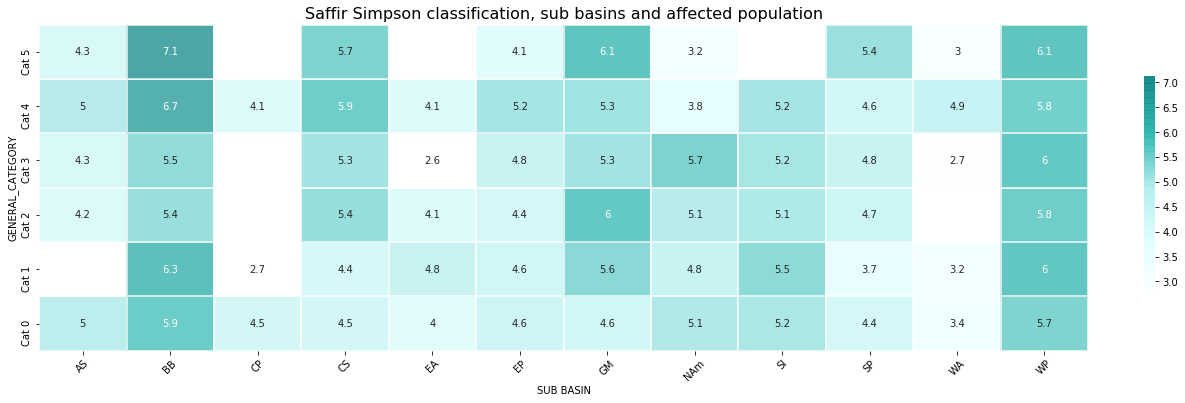

In [185]:
fig, ax = plt.subplots(figsize=(20,6))

#We use the function crosstab in pandas to create a contingency table, crossing USA_SSHS and SUB BASIN by computing the mean of the affected population
sns.heatmap(cont_table,
            cmap=aquas, #'RdPu',
            alpha= 0.7,
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ax = ax,
            annot = True).set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(ylim=(0, 6));

ax.set_title("Saffir Simpson classification, sub basins and affected population", fontsize= 16);

Here we consider the tropical depressions and tropical storms together as Cat 0. We can do this because there are little tropical depressions in our data. Most of the basins have the highest number of affected people increasing as the category of the cyclone increases, except the North Atlantic basin for which we have very little data.

In the West Pacific basin, for which we have most data, the mean affected people by the cyclone is going upwards most of the time when the category of the cyclone increases.

After this, we will include the feature ``GENERAL_CATEGORY`` as a dummy variable in our data set.

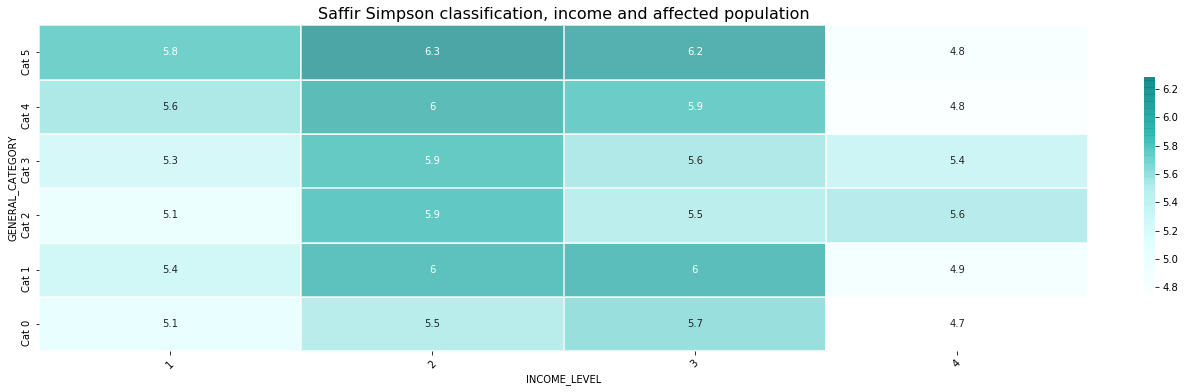

In [186]:
cont_table2 = pd.crosstab(md["GENERAL_CATEGORY"], 
                         md["INCOME_LEVEL"], 
                         values = md["TOTAL_AFFECTED"], 
                         aggfunc= "mean").sort_values("GENERAL_CATEGORY")

for col in cont_table2.columns:
    cont_table2[col] = cont_table2[col].apply(lambda x: math.log(x, 10))
fig, ax = plt.subplots(figsize=(20,6))

#We use the function crosstab in pandas to create a contingency table, crossing category and income
#by computing the mean of the affected population
sns.heatmap(cont_table2,
             cmap=aquas, #'RdPu',
            alpha= 0.7, 
            cbar_kws={'fraction' : 0.01}, # shrink colour bar
            linewidth=1, # space between cells
            ax = ax,
            annot = True).set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set(ylim=(0, 6));

ax.set_title("Saffir Simpson classification, income and affected population", fontsize= 16);

We can see than, in general countries with higher income level have less affected population in each cyclone category. Critical sectors are countries with ``INCOME_LEVEL`` Low middle and High Middle.

We will include ``INCOME_LEVEL`` as a dummy variable in our data set.

## 4.5. Plus: Correlation matrix for our numerical features

We will construct a function which allows us to do the same procedure for different datasets:

In [187]:
def get_correlation_matrix(data, method_corr):
    numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
    data_num = data[numerical_variables].copy()
    corr_numbers = data_num.corr(method = method_corr)
    corr_num_list = list(corr_numbers[abs(corr_numbers["TOTAL_AFFECTED"])>=0.10].index)
    corr_plot = corr_numbers[corr_numbers.index.isin(corr_num_list)][corr_num_list]
    n = len(corr_num_list)
    
    mask = np.zeros_like(corr_plot, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    
    fig, ax = plt.subplots(figsize=(13,15))

    sns.heatmap(corr_plot,
                mask = mask,
                annot = True,
                square=True,
                linewidth=1,# space between cells
                cmap= trop_rev,
                cbar_kws={'fraction' : 0.03}, # shrink colour bar
                ax = ax,
               );
    ax.set(ylim=(0, n));
    ax.set_title(method_corr.capitalize() +" correlation coefficient: correlation with TOTAL_AFFECTED >= 0.10", fontsize=17);

def get_correlation_features(data, method_corr, col):
    numerical_variables = list(data.select_dtypes(include=['float64', "int"]).columns)
    data_num = data[numerical_variables].copy()
    corr_numbers = data_num.corr(method = method_corr)
    corr_num_list = list(corr_numbers[abs(corr_numbers["TOTAL_AFFECTED"])>=0.10].index)
    corr_plot = corr_numbers[corr_numbers.index.isin(corr_num_list)][corr_num_list]
    corr_plot = corr_plot[[col]]
    corr_plot["absolute coeficient"] = corr_plot[col].apply(lambda x: abs(x))
    corr_plot = corr_plot.sort_values("absolute coeficient", ascending= False).reset_index()
    corr_plot = corr_plot.rename(columns = {"index": "Features", col: "Correlation coeficient"})
    return corr_plot[["Features", "Correlation coeficient"]].drop(0, axis = 0)

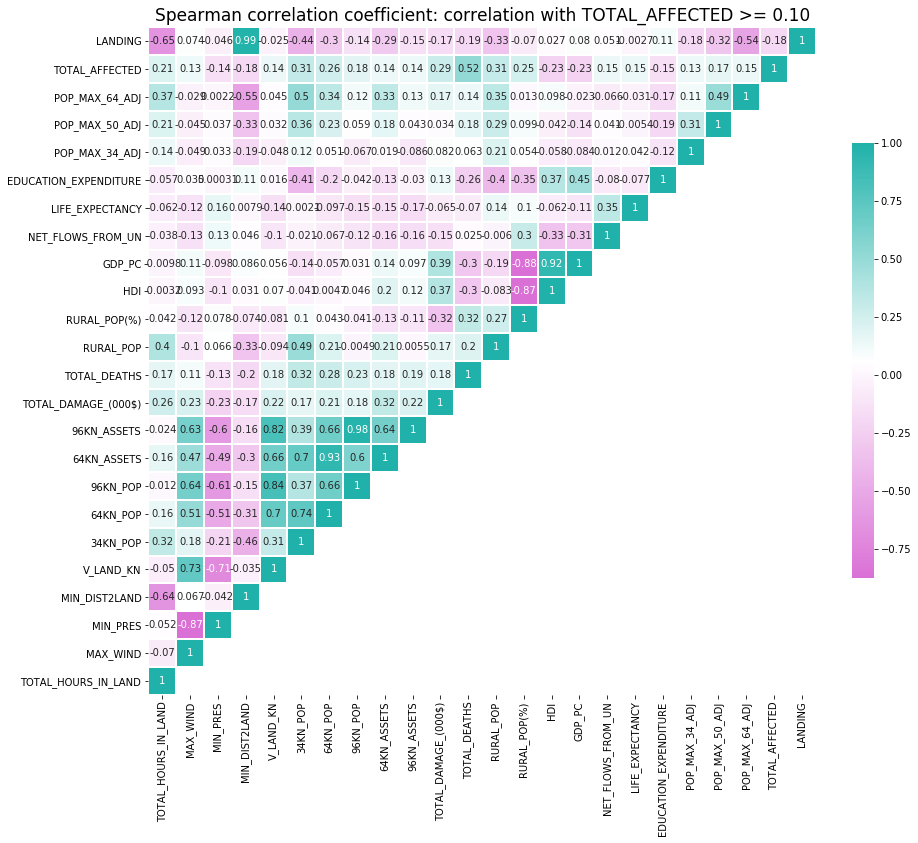

In [166]:
get_correlation_matrix(model_data2, "spearman")

# 5. How is the distribution of the population affected in our data?

Observe that the distribution of the natural logarithm of our target variable is approximately normal, so ``TOTAL_AFFECTED`` has a distribution log normal. However, the variable without any transformation is extremely positive skewed with many upper outliers.


In [50]:
fig = px.histogram(model_data2["TOTAL_AFFECTED"],#.apply(lambda x: math.log(x)), 
                   x="TOTAL_AFFECTED", 
                   histnorm='probability density',
                   color_discrete_sequence = ['rgb(66,186,185)'],
                   labels = {"TOTAL_AFFECTED": "Total affected"},
                   log_y=True,
                   template = 'plotly_white')

fig.update_layout(
    title_text = 'Population affected by cyclones')

fig.show()

In [51]:
fig = px.histogram(model_data2["TOTAL_AFFECTED"].apply(lambda x: math.log(x, 10)), 
                   x="TOTAL_AFFECTED", 
                   histnorm='probability density',
                   color_discrete_sequence = ['rgb(66,186,185)'],
                   labels = {"TOTAL_AFFECTED": "log(Total affected)"},
                   template = 'plotly_white')

fig.update_layout(
    title_text = 'Population affected by cyclones: Log distribution')

fig.show()

# 6. Outliers handling



In [52]:
fig = px.box(model_data2,
             y=model_data2["TOTAL_AFFECTED"], 
             color_discrete_sequence=['rgb(66,186,185)'],
            points="all",
             log_y= True,
            template = 'plotly_white')

fig.update_layout(
    title_text = 'Outliers presence: Total people affected')


fig.show()

There is a huge presence of outliers in our data. This phenomena is replicated across almost each sub-basin and every category of cyclones.

In [53]:
fig = px.box(model_data2,
             x= model_data2["SUB BASIN"],
             y=model_data2["TOTAL_AFFECTED"], 
             color = model_data2["SUB BASIN"],
             color_discrete_sequence=px.colors.qualitative.Pastel,
            # points="all",
             log_y= True,
            template = 'plotly_white')

fig.update_layout(
    title_text = 'Outliers presence: Total people affected in each Sub-basin')


fig.show()

In [54]:
fig = px.box(model_data2,
             x= model_data2["GENERAL_CATEGORY"],
             y=model_data2["TOTAL_AFFECTED"], 
             color = model_data2["GENERAL_CATEGORY"],
             color_discrete_sequence=px.colors.qualitative.Pastel,
            # points="all",
             log_y= True,
            template = 'plotly_white')

fig.update_layout(
    title_text = 'Outliers presence: Total people affected in each cyclone category')


fig.show()

# 7. Feature engineering, handling categorical variables

After seeing the relevance of certain variables for our model, we decided to keep ``GENERAL_CATEGORY`` as a categorical variable and ``SUB BASIN``. Also, we will introduce a boolean variable for landing or not landing:

In [55]:
# get dummy variables
model_data2 = pd.get_dummies(model_data2, columns=["GENERAL_CATEGORY", "INCOME_LEVEL"], prefix = ["GEN", "INCOME"])

In [56]:
model_data2["LANDING"] = model_data2["DATE_LAND_START"].apply(lambda x: 0 if x!="No landing" else 1)

In [57]:
model_data2.set_index("SID").to_excel("Data_output/data_final_fabi.xlsx")

Since we want to predict affected population, data about deaths and damage are a posteriori. Therefore, we drop those variables as well:

In [58]:
apriori = model_data2.drop(columns = ["DATE_LAND_START", "DATE_LAND_END", "MAX_USA_SSHS", "MAX_USA_SSHS_INLAND", "NATURE", "TOTAL_DEATHS", "TOTAL_DAMAGE_(000$)"])

In [59]:
apriori.set_index("SID").to_excel("Data_output/apriori_data.xlsx")

### 7.1. **What are the most correlated variables with ``TOTAL_AFFECTED``?**

In [60]:
get_correlation_features(model_data2, "spearman", "TOTAL_AFFECTED").head(12)

,Features,Correlation coeficient
1,TOTAL_DEATHS,0.521623
2,34KN_POP,0.313103
3,RURAL_POP,0.305599
4,TOTAL_DAMAGE_(000$),0.287962
5,64KN_POP,0.260846
6,RURAL_POP(%),0.249751
7,HDI,-0.230856
8,GDP_PC,-0.225501
9,TOTAL_HOURS_IN_LAND,0.209744
10,96KN_POP,0.184835


The top 10 most important features, out of the a posteriori ones, are:

* 34_KN_POP
* Rural population
* 64_KN_POP
* Rural population share
* Human Development Index (HDI)
* GDP per capita
* Total hours in land
* 96_KN_POP
* Landing (yes/no)
* Minimum distance to land

None of the a priori variables shows high correlation in general. 

### 7.2. What is the proportion of cyclones that actually land?

In [61]:
#creating tidy table
landing = (apriori.groupby("LANDING").agg({"DATE_START": "count", "TOTAL_AFFECTED": "sum"})
                   .reset_index()
                   .rename(columns = {"DATE_START": "Number of cyclones"}))

landing["LANDING"] = landing["LANDING"].apply(lambda x: "Landing"  if x== 0 else "No landing")

In [64]:
landing

,LANDING,Number of cyclones,TOTAL_AFFECTED
0,Landing,773,542364627
1,No landing,218,34018394


In [68]:
palette = ['rgb(167,211,212)', 'rgb(199, 93, 171)'] 

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=["Number of cyclones", 'People affected'])

fig.add_trace(go.Pie(labels=landing["LANDING"], 
                     values=landing["Number of cyclones"],
                      hole=.3,
                      marker_colors= palette,
                      name = ""), 1, 1)

fig.add_trace(go.Pie(labels=landing["LANDING"], 
                     values=landing["TOTAL_AFFECTED"], 
                     hole=.3,
                     marker_colors= palette,
                     name = ""), 1, 2)

fig.update_layout(title_text='Cyclones landing and people affected')
fig.show()


Almost 3 of each 4 cyclones present in our data did land. Those cyclones are responsible for almost 95% of the affected population in our data. See the plots generated with plotly [here](https://github.com/omdena/wfpdisrel/blob/master/%23task3-model/model-e-RandomForest/Plots/cyclones_landing.png)



# 6. Working with Random Forest Regressor

First we will import the relevant libraries.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error, explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV

In [70]:
train = apriori.copy()

In [71]:
train.drop(columns = ["SID", "NAME", "ISO", "YEAR", "SUB BASIN", "DATE_START", "DATE_END" ], inplace= True)

In [72]:
train.columns

Index(['MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND',
       'LAT_MAX_WINDS', 'LON_MAX_WINDS', 'LAT_MIN_DIST2LAND',
       'LON_MIN_DIST2LAND', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS', 'POP_DEN_SQ_KM',
       'RURAL_POP', 'RURAL_POP(%)', 'HDI', 'ARABLE_LAND', 'CEREAL_YIELD',
       'FOOD_PRODUCTION_INDEX', 'GDP_PC', 'NET_FLOWS_FROM_UN',
       'LIFE_EXPECTANCY', 'EDUCATION_EXPENDITURE', 'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'TOTAL_AFFECTED', 'GEN_Cat 1',
       'GEN_Cat 2', 'GEN_Cat 3', 'GEN_Cat 4', 'GEN_Cat 5', 'GEN_TD', 'GEN_TS',
       'INCOME_High', 'INCOME_High_Middle', 'INCOME_Low', 'INCOME_Low_Middle',
       'LANDING'],
      dtype='object')

Before go further with the modelling part, it is necessary to fill the null values in the data set. We wil create a function to do so, in order to validate the performance of different strategies to fill the null values.

In [73]:
from sklearn.impute import SimpleImputer

In [74]:
def imput_values(data, strategy):
    """
    Returns data imputed following the strategy specified.
    Strategy can be mean, median, most_frequent
    """
    imp_trial=SimpleImputer(missing_values=np.NaN, strategy=strategy)
    idata=pd.DataFrame(imp_trial.fit_transform(data))
    idata.columns=data.columns
    idata.index=data.index
    return idata


If we want to scale our data using logarithms, there is a detail. As the domain of $log_{a} = \mathbb{R}^{>0}$ for any real $a>0$, we have to modify the scaler accordingly. Since all our numerical features take values that are at least 0, a simple handling of the function will allow us to scale any of those features accordingly.

In [75]:
def log_scale(data, cols, base):
    """
    Apply log in the base specified to cols, a subset of data.columns.
    The function prevents to calculate the logarithm of zero given that
    all values in cols are at least 0.
    If base == "e", it computes the natural logarithm.
    """
    log_data = data.copy()
    if base == "e":
        for col in cols:
            log_data[col] = log_data[col].apply(lambda x: math.log(x+1))
    else:
        for col in cols:
            log_data[col] = log_data[col].apply(lambda x: math.log(x+1, base))
    return log_data

In [76]:
def revert(array, base):
    if base == "e":
        return np.exp(array) -1
    else:
        return base**array -1
    

Now, we create a couple of model validator functions:

In [188]:
RandomForestRegModel= RandomForestRegressor(random_state=142)


def model_validator(data, strategy, test_size, cols, target):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of features of data without including the target variable.
    """
    
    idata= imput_values(data, strategy)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=142)
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = cols)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color ="lightseagreen",
                                       alpha = 0.7,
                                       title = "Feature importance" )
    print("Metrics results:")
    print("Inputting values following strategy {}".format(strategy))
    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Mean squared logarithmic error (RMSLE): {}".format(math.sqrt(mean_squared_log_error(y_itest, pred_i))))
    print("Explained Variance: {}".format(explained_variance_score(y_itest, pred_i)))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_itest, pred_i, pred_i)))
    print("Median Absolute Error: {}".format(median_absolute_error(y_itest, pred_i)))
    

    

In [189]:
def model_validator_log(data, strategy, test_size, cols, target, cols_to_be_transformed, base):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of the columns of data without including the target variable.
    cols_to_be_transformed is a subset of data.columns to be transformed via log_scale function using
    the base specified.
    """
    idata= imput_values(data, strategy)
    idata = log_scale(idata, cols_to_be_transformed, base)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=42)
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
    feat_importances = pd.Series(model_i.feature_importances_, index = cols)
    feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color ="lightseagreen",
                                       alpha = 0.7,
                                       title = "Feature importance" )
    print("Results metrics with logarithmic scaling in base {}".format(base))
    print("Inputting values following strategy {}".format(strategy))

    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Explained Variance: {}".format(explained_variance_score(revert(y_itest, base), revert(pred_i, base))))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(revert(y_itest, base), revert(pred_i, base))))
    print("Squared Root Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(revert(y_itest, base), revert(pred_i, base)))))
    print("Distorted RMSE (aka almost RMSLE) : {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Median Absolute Error: {}".format(median_absolute_error(revert(y_itest, base), revert(pred_i, base))))
    

We have a default selection of features. Let us try out the performance of our model within this data:

In [79]:
#data set train without log transformations
trial = train.copy()

In [80]:
features = ['MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND',
       'LAT_MAX_WINDS', 'LON_MAX_WINDS', 'LAT_MIN_DIST2LAND',
       'LON_MIN_DIST2LAND', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 
        'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', #'34KN_POP', '64KN_POP', '96KN_POP',
       'POP_DEN_SQ_KM',
       'RURAL_POP', 'RURAL_POP(%)', 'HDI', #'ARABLE_LAND', 'CEREAL_YIELD',
       #'FOOD_PRODUCTION_INDEX', 'GDP_PC', #'NET_FLOWS_FROM_UN',
       #'LIFE_EXPECTANCY', 'EDUCATION_EXPENDITURE',
        'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'GEN_Cat 1',
       'GEN_Cat 2', 'GEN_Cat 3', 'GEN_Cat 4', 'GEN_Cat 5', 'GEN_TD', 'GEN_TS',
       #'INCOME_High', 'INCOME_High_Middle', 'INCOME_Low', 'INCOME_Low_Middle',
       'LANDING']

In [81]:
to_transform = ['34KN_POP', '64KN_POP', '96KN_POP',
        'POP_DEN_SQ_KM',
       'RURAL_POP', 'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',"TOTAL_AFFECTED" ]

### Running models with scaled features

Results metrics with logarithmic scaling in base e
Inputting values following strategy median
R2 Score: 0.2331639564211384
Explained Variance: 0.01744884498643895
Mean Absolute Error (MAE): 565581.0012814814
Squared Root Mean Squared Error (RMSE): 2325062.268162511
Distorted RMSE (aka almost RMSLE) : 2.635025903468463
Median Absolute Error: 40409.27814291451


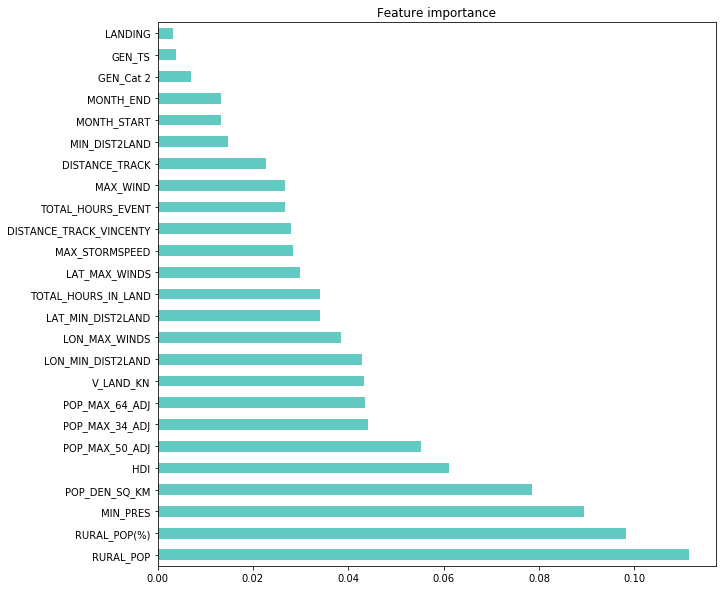

In [190]:
model_validator_log(trial, "median", 0.25, features, "TOTAL_AFFECTED", to_transform, "e")

Results metrics with logarithmic scaling in base 10
Inputting values following strategy median
R2 Score: 0.23574736502992066
Explained Variance: 0.01715065544138883
Mean Absolute Error (MAE): 563554.4370875198
Squared Root Mean Squared Error (RMSE): 2325727.309731851
Distorted RMSE (aka almost RMSLE) : 1.1424479261470808
Median Absolute Error: 40807.940771911504


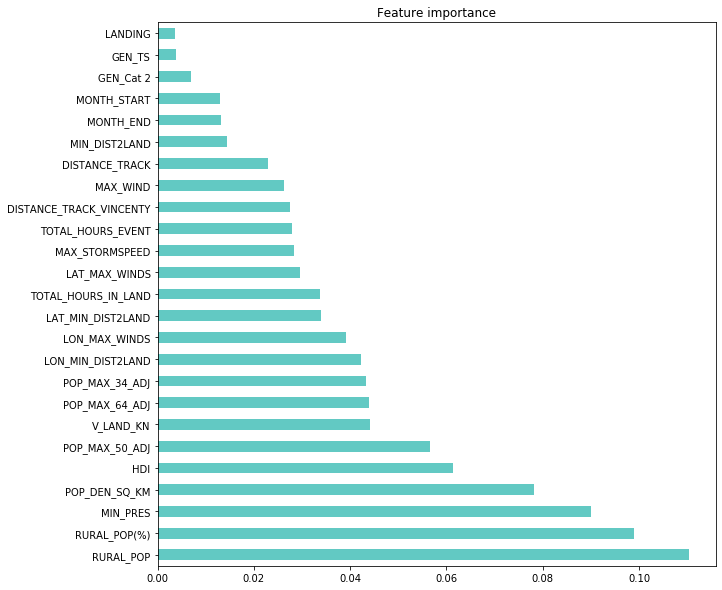

In [191]:
model_validator_log(trial, "median", 0.25, features, "TOTAL_AFFECTED", to_transform, 10)

**Conclusions**

* The choose of base for logarithmic transformations does not affect that much the performnce of the Random forest.
* After excluding a lot of features our model show better performance.

### Running models without scaling features

Metrics results:
Inputting values following strategy median
R2 Score: 0.2843916899085649
Squared root of Mean Squared Error (RMSE): 1634612.1564910037
Mean squared logarithmic error (RMSLE): 3.8837107823362036
Explained Variance: 0.2934524706523556
Mean Absolute Error (MAE): 2535536.672339693
Median Absolute Error: 228571.60499999998


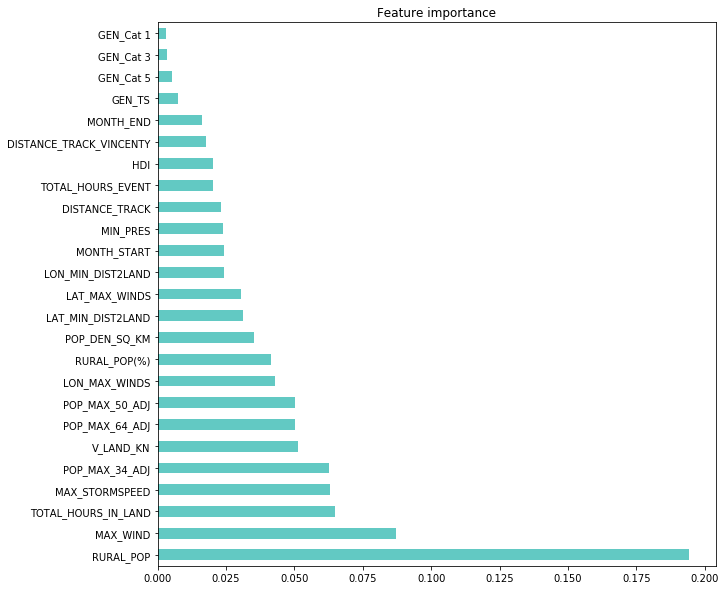

In [192]:
model_validator(trial, "median", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy median
R2 Score: 0.3474327057890073
Squared root of Mean Squared Error (RMSE): 1588940.5424794087
Mean squared logarithmic error (RMSLE): 3.9293167426719373
Explained Variance: 0.3574507120194903
Mean Absolute Error (MAE): 2504745.7346690064
Median Absolute Error: 245850.03


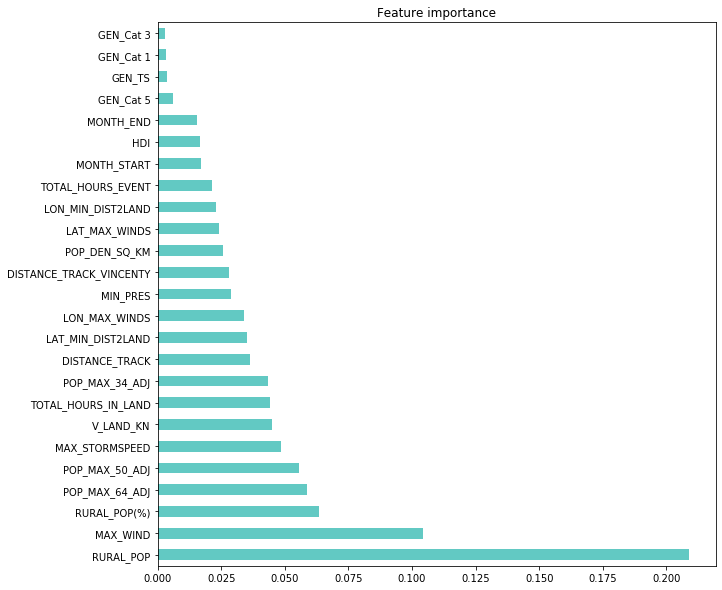

In [193]:
model_validator(trial, "median", 0.24, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy mean
R2 Score: 0.2677164524884629
Squared root of Mean Squared Error (RMSE): 1653547.5006501987
Mean squared logarithmic error (RMSLE): 3.9045613369260863
Explained Variance: 0.278276207782745
Mean Absolute Error (MAE): 2635469.2738527204
Median Absolute Error: 231864.535


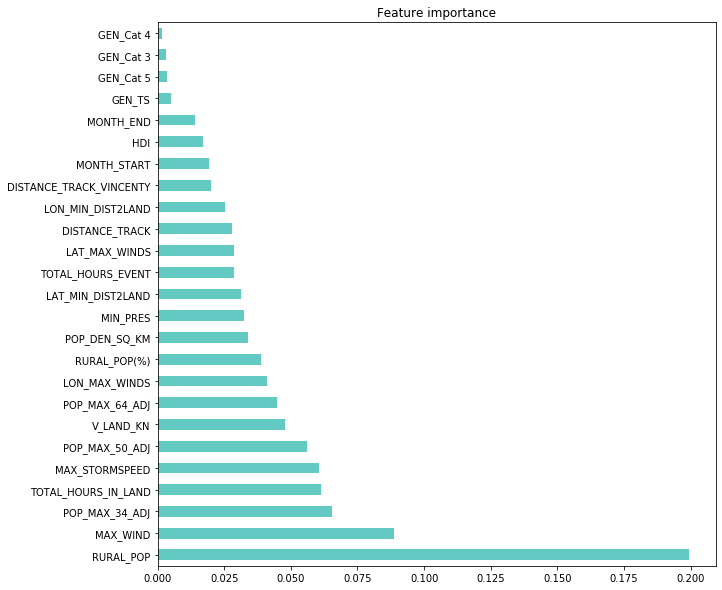

In [194]:
model_validator(trial, "mean", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy most_frequent
R2 Score: 0.2735622735155444
Squared root of Mean Squared Error (RMSE): 1646934.1390782336
Mean squared logarithmic error (RMSLE): 3.897360000852362
Explained Variance: 0.28486902420314186
Mean Absolute Error (MAE): 2565505.44476047
Median Absolute Error: 233758.37


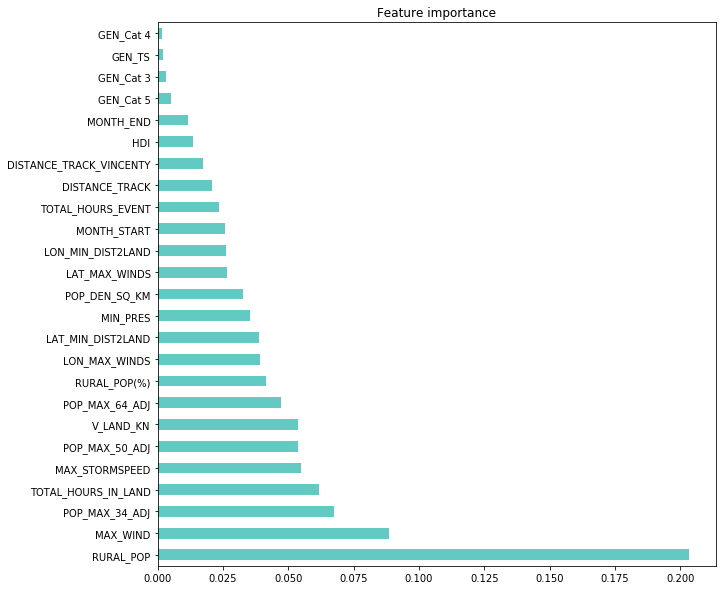

In [195]:
model_validator(trial, "most_frequent", 0.25, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy mean
R2 Score: 0.2311452684492612
Squared root of Mean Squared Error (RMSE): 1611259.2450594935
Mean squared logarithmic error (RMSLE): 3.8998423381104383
Explained Variance: 0.24947196557060325
Mean Absolute Error (MAE): 2640671.9249530286
Median Absolute Error: 218674.415


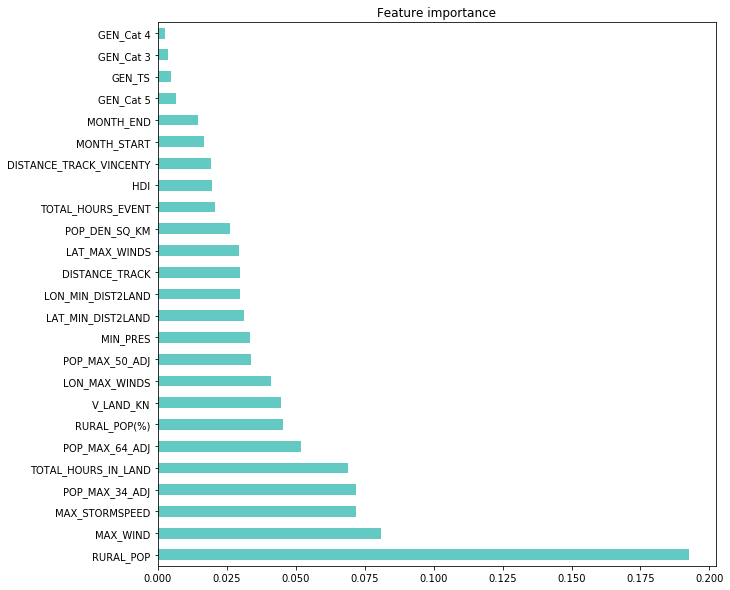

In [196]:
model_validator(trial, "mean", 0.30, features, "TOTAL_AFFECTED")

### Using all the features

This was my first trial. Using the feature importance, I was dropping not relevant features and the accuracy improves a bit.

In [197]:
features2 = ['MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND',
       'LAT_MAX_WINDS', 'LON_MAX_WINDS', 'LAT_MIN_DIST2LAND',
       'LON_MIN_DIST2LAND', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 
        'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'POP_DEN_SQ_KM',
       'RURAL_POP', 'RURAL_POP(%)', 'HDI', 'ARABLE_LAND', 'CEREAL_YIELD',
       'FOOD_PRODUCTION_INDEX', 'GDP_PC', 'NET_FLOWS_FROM_UN',
       'LIFE_EXPECTANCY', 'EDUCATION_EXPENDITURE',
        'POP_MAX_34_ADJ',
       'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'GEN_Cat 1',
       'GEN_Cat 2', 'GEN_Cat 3', 'GEN_Cat 4', 'GEN_Cat 5', 'GEN_TD', 'GEN_TS',
       'INCOME_High', 'INCOME_High_Middle', 'INCOME_Low', 'INCOME_Low_Middle',
       'LANDING']

Metrics results:
Inputting values following strategy most_frequent
R2 Score: 0.21533268812602246
Squared root of Mean Squared Error (RMSE): 1627743.8270077384
Mean squared logarithmic error (RMSLE): 3.959925560918799
Explained Variance: 0.23425230027096167
Mean Absolute Error (MAE): 2544468.2592901667
Median Absolute Error: 265781.865


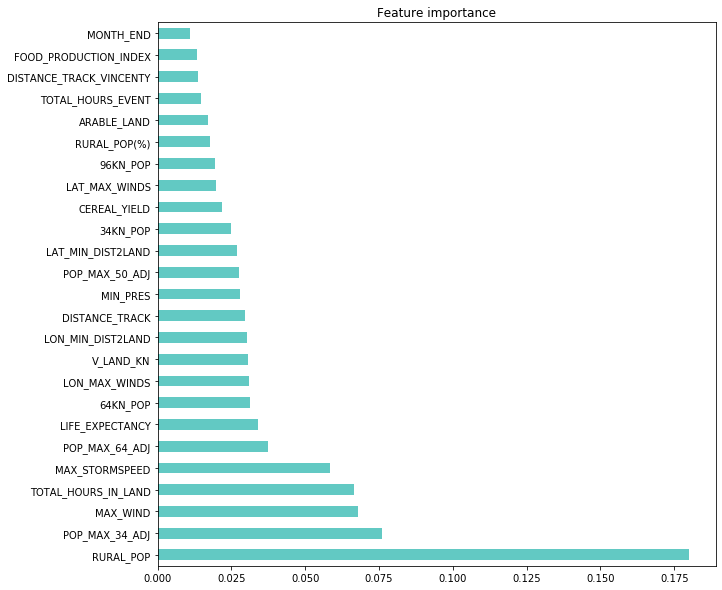

In [198]:
model_validator(trial, "most_frequent", 0.30, features2, "TOTAL_AFFECTED")

**Conclusions**

* Random forest give us better metrics without logarithmic transformations. We reach almost 0.30 in R^2 score without any hyper parameter tuning. 

* The strategy to fill null values which improves the metrics are median and most frequent.

* The test size is better at 0.30 when choosing most_frequent strategy to fill nulls and 0.25 when using medians.

### 6.  Predictions vs Observations 

We will use next piece of code to plot the observed and predicted values as a function of the index value. The observed values are ranked in increasing order to make the plot more understandable.

In [199]:
def predictions_plot(data, strategy, test_size, cols, target):
    """
    Returns metrics and feature importances after running Random Forest algorithm
    on a dataset data, following the inputation strategy strategy, with a test size defined.
    cols is a subset of features of data without including the target variable.
    """
    
    idata= imput_values(data, strategy)
    X_i = idata[cols].values
    y_i = idata[target].values
    X_itrain, X_itest, y_itrain, y_itest = train_test_split(X_i, y_i, test_size=test_size, random_state=142)
    model_i = RandomForestRegModel.fit(X_itrain, y_itrain)
    pred_i = model_i.predict(X_itest)
        
    print("Metrics results:")
    print("Inputting values following strategy {}".format(strategy))
    print("R2 Score: {}".format(r2_score(y_itest, pred_i)))
    print("Squared root of Mean Squared Error (RMSE): {}".format(math.sqrt(mean_squared_error(y_itest, pred_i))))
    print("Mean squared logarithmic error (RMSLE): {}".format(math.sqrt(mean_squared_log_error(y_itest, pred_i))))
    print("Explained Variance: {}".format(explained_variance_score(y_itest, pred_i)))
    print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_itest, pred_i, pred_i)))
    print("Median Absolute Error: {}".format(median_absolute_error(y_itest, pred_i)))
    
    obs_pred = pd.DataFrame({'Observed':y_itest, 'Predicted':pred_i})
    obs_pred.sort_values("Observed", inplace= True)
    obs_pred.reset_index(drop = True, inplace= True)
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(obs_pred.index,
            obs_pred["Predicted"], 
            'o', c='orchid', 
            alpha=0.5, 
            markeredgecolor='none',
            label = "Predicted values")
    ax.plot(obs_pred.index,
            obs_pred["Observed"], 
            c= "lightseagreen",
            alpha= 0.6,
            marker='.', 
            linestyle=':',
            label = "Observed values")
    ax.set_yscale('log')
    ax.set_title('Values observed and predicted', fontsize= 12)
    ax.set_ylabel('Affected population', fontsize=12);
    ax.set_xlabel('Number of observations', fontsize=14)
    leg = ax.legend(loc='lower right');


Metrics results:
Inputting values following strategy median
R2 Score: 0.3474327057890073
Squared root of Mean Squared Error (RMSE): 1588940.5424794087
Mean squared logarithmic error (RMSLE): 3.9293167426719373
Explained Variance: 0.3574507120194903
Mean Absolute Error (MAE): 2504745.7346690064
Median Absolute Error: 245850.03


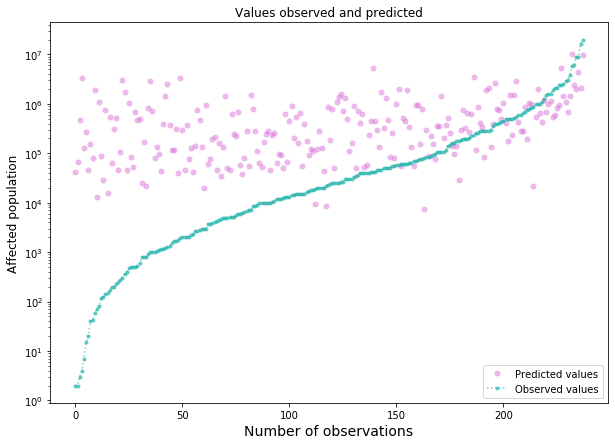

In [200]:
predictions_plot(trial, "median", 0.24, features, "TOTAL_AFFECTED")

Metrics results:
Inputting values following strategy median
R2 Score: 0.2843916899085649
Squared root of Mean Squared Error (RMSE): 1634612.1564910037
Mean squared logarithmic error (RMSLE): 3.8837107823362036
Explained Variance: 0.2934524706523556
Mean Absolute Error (MAE): 2535536.672339693
Median Absolute Error: 228571.60499999998


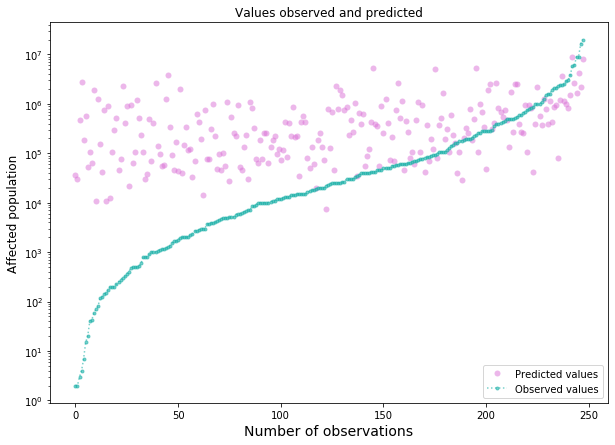

In [201]:
predictions_plot(trial, "median", 0.25, features, "TOTAL_AFFECTED")

**Conclusion**

* Our model is not performing well when taking samples of small affected population. It seems that by restringing our model to samplings having big affected population, our model will perform better.

* Using min_max scaler won't be solve the problem, given the huge gap between the values and possibly tuning hyperparameters will not be helpful given our skewed data set.  

